In [16]:
import random
from datetime import datetime, timedelta
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
import tsd

In [ ]:
# enter your credentials in a file .netrc in your user home directory in the following form:

# machine apihub.copernicus.eu
# login <your username>
# password <your password>

# api = SentinelAPI(None, None)
api = SentinelAPI('romain.dijoux@univ-tlse3.fr', 'aZ%B5^pmGhx#*nvm', 'https://finder.code-de.org/resto/api/collections/')

# footprint = f'POINT({80} {80})'
footprint = None
date='20220101', '20220201'
products = api.query(footprint, date=date, producttype='GRD', platformname='Sentinel-1', processinglevel = 'Level-2A')

In [17]:
import json
import requests
def get_access_token(username: str, password: str) -> str:
    data = {
        "client_id": "cdse-public",
        "username": username,
        "password": password,
        "grant_type": "password",
        }
    try:
        r = requests.post("https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token",
        data=data,
        )
        r.raise_for_status()
    except Exception as e:
        raise Exception(
            f"Access token creation failed. Reponse from the server was: {r.json()}"
            )
    return r.json()["access_token"]


access_token = get_access_token("charliegrand31@gmail.com", "bL29k8^HXJA$Ko")

In [ ]:
import tsd

In [18]:
def sampleCoord():
    return random.uniform(-90, 90), random.uniform(-180, 180)

def sampleDate(start_date, end_date):
    start_datetime = datetime.strptime(start_date, '%Y-%m-%d')
    end_datetime = datetime.strptime(end_date, '%Y-%m-%d')
    date_range = (end_datetime - start_datetime).days
    random_days = random.randint(0, date_range)
    result_date = start_datetime + timedelta(days=random_days)
    result_date_tupled = start_datetime + timedelta(days=random_days) - timedelta(days=30)
    return result_date_tupled.strftime('%Y%m%d'), result_date.strftime('%Y%m%d')

def sampleSentinelData(api, start_date, end_date):
    date = sampleDate(start_date, end_date)
    longitude, latitude = sampleCoord()
    footprint = f'POINT({longitude} {latitude})'

    print("query")
    products = api.query(footprint, date=date, producttype='GRD', platformname='Sentinel-1')
    if products:
        product_id = list(products.keys())[0]
        print("download")
        api.download(product_id, directory_path='samples/sentinel1/')
        print("done")
    else:
        print("No Sentinel-1 data found for the specified date and location.")

In [19]:
sampleSentinelData(api, '2022-01-01', '2022-01-31')

query


SentinelAPIError: HTTP status 403 Forbidden: 

1760 5272 1413 5048 1242 5955


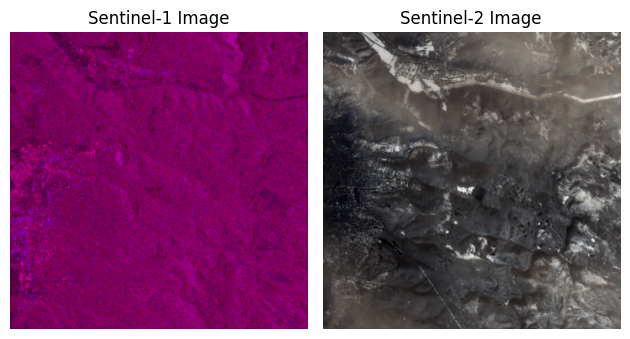

In [21]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np


def plot_sentinel1_image(vv, vh, axes):
    # Normalize the bands to 0-255 range
    band1_norm = np.interp(vv, (vv.min(), vv.max()), (0, 255))
    band2_norm = np.interp(vh, (vh.min(), vh.max()), (0, 255))

    # Create a 3-channel image with the bands mapped to R and G channels
    rgb_image = np.zeros((vv.shape[0], vv.shape[1], 3), dtype=np.uint8)
    rgb_image[:, :, 0] = band2_norm.astype(np.uint8)  # R channel
    rgb_image[:, :, 2] = band1_norm.astype(np.uint8)  # B channel

    # Display the image
    axes.axis('off')
    axes.imshow(rgb_image)
    axes.set_title("Sentinel-1 Image")


def plot_sentinel2_image(r, g, b, axes):
    # Normalize the bands to 0-255 range
    band1_norm = np.interp(r, (r.min(), r.max()), (0, 255))
    band2_norm = np.interp(g, (g.min(), g.max()), (0, 255))
    band3_norm = np.interp(b, (b.min(), b.max()), (0, 255))

    print(r.min(), r.max(), g.min(), g.max(), b.min(), b.max())
    # Create a 3-channel image with the bands mapped to R and G channels
    rgb_image = np.zeros((r.shape[0], r.shape[1], 3), dtype=np.uint8)
    rgb_image[:, :, 0] = band1_norm.astype(np.uint8)  # R channel
    rgb_image[:, :, 1] = band2_norm.astype(np.uint8)  # G channel
    rgb_image[:, :, 2] = band3_norm.astype(np.uint8)  # B channel

    # Display the image
    axes.axis('off')
    axes.imshow(rgb_image)
    axes.set_title("Sentinel-2 Image")


# Open the GeoTIFF image
sentinel1_image_path = "sentinel1_example.tif"
sentinel2_image_path = "sentinel2_example.tif"

sentinel1 = rasterio.open(sentinel1_image_path)
sentinel2 = rasterio.open(sentinel2_image_path)

# Read the bands
vv = sentinel1.read(1)
vh = sentinel1.read(2)

r = sentinel2.read(3)
g = sentinel2.read(2)
b = sentinel2.read(1)

fig, axes = plt.subplots(1,2)

plot_sentinel1_image(vv, vh, axes[0])
plot_sentinel2_image(r, g, b, axes[1])

plt.tight_layout()
plt.show()


# Close the dataset
dataset = None